--- Environment Info ---
Observation Space (State): Shape is (4,), which means it's 4 numbers.
Action Space (Moves): Size is 2, which means there are 2 possible moves (0 for left, 1 for right).
------------------------

--- Running 10 random steps ---
Step 1: Action=0, Reward=1.0
Step 2: Action=1, Reward=1.0
Step 3: Action=1, Reward=1.0
Step 4: Action=1, Reward=1.0
Step 5: Action=0, Reward=1.0
Step 6: Action=0, Reward=1.0
Step 7: Action=1, Reward=1.0
Step 8: Action=1, Reward=1.0
Step 9: Action=1, Reward=1.0
Step 10: Action=0, Reward=1.0


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,610 (18.01 KB)

 Trainable params: 4,610 (18.01 KB)

 Non-trainable params: 0 (0.00 B)

Resuming training (FAST MODE)...
Episode: 500, Avg Reward: 10.00

Training complete!
Setting up virtual display...


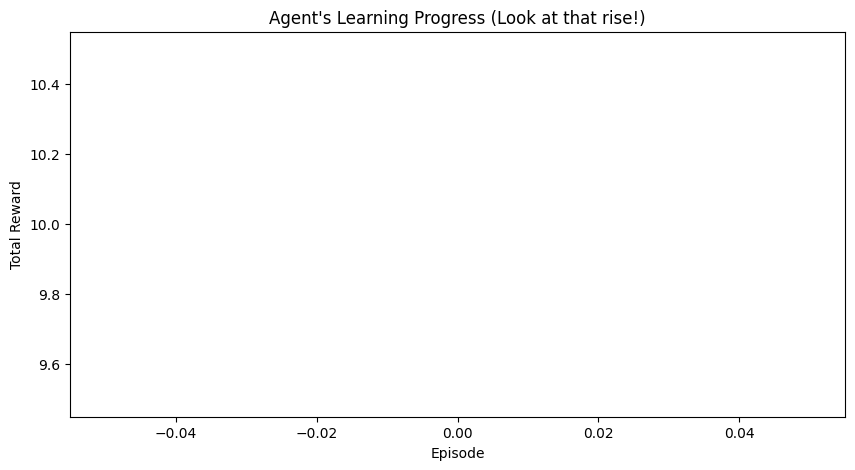

Recording showcase episode... (This might take a moment)


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Displaying video...


In [6]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Let's create our CartPole environment!
env = gym.make("CartPole-v1")

# Every environment has an observation space and an action space.
# This tells us what the AI "sees" and what it "can do."
print("--- Environment Info ---")
obs_space_shape = env.observation_space.shape
action_space_size = env.action_space.n
print(f"Observation Space (State): Shape is {obs_space_shape}, which means it's {obs_space_shape[0]} numbers.")
print(f"Action Space (Moves): Size is {action_space_size}, which means there are {action_space_size} possible moves (0 for left, 1 for right).")
print("------------------------\n")

# --- Let's see our "dumb" agent in action! ---

# We always start a new game (or "episode") by resetting the environment.
# This gives us our very first observation (the starting state of the game).
observation, info = env.reset()

print("--- Running 10 random steps ---")
for i in range(10):
    # This is the "dumb" part: our agent just picks a random action.
    random_action = env.action_space.sample()

    # The `env.step()` function is the most important one.
    # It tells the environment to perform our chosen action.
    # It returns 5 crucial pieces of information:
    observation, reward, terminated, truncated, info = env.step(random_action)

    print(f"Step {i+1}: Action={random_action}, Reward={reward}")

    # If `terminated` or `truncated` is True, it means the game is over.
    if terminated or truncated:
        print("Pole has fallen! The episode is over.")
        # We would reset the environment here to start a new game.
        break

# It's good practice to close the environment when you're done.
env.close()


# The input to our brain is the state (4 numbers).
input_shape = env.observation_space.shape
# The output is a Q-value for each possible action (2 actions).
num_actions = env.action_space.n

# Let's build the model using the Keras Sequential API
model = tf.keras.Sequential([
    # Our input layer needs to know the shape of our state
    layers.Input(shape=input_shape),

    # Hidden "thinking" layers. We use 'relu' for the activation.
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),

    # The output layer gives us the Q-values for each action.
    # We use 'linear' activation here because we want raw Q-values,
    # not probabilities.
    layers.Dense(num_actions, activation='linear')
])

# Let's see a summary of our agent's brain
model.summary()


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.index = 0

    # Save a new experience (memory) to the buffer
    def store_experience(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None) # Make space if the buffer isn't full

        # Save the experience at the current index, wrapping around if needed
        self.buffer[self.index] = (state, action, reward, next_state, done)
        self.index = (self.index + 1) % self.capacity

    # Sample a random batch of memories
    def sample(self, batch_size):
        # Generate random indices
        batch_indices = np.random.choice(len(self.buffer), batch_size, replace=False)

        # Unzip the batch of experiences into separate lists
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in batch_indices])

        return (np.array(states),
                np.array(actions),
                np.array(rewards),
                np.array(next_states),
                np.array(dones))

    # A simple helper to check if the buffer is full enough to start sampling from
    def is_ready(self, batch_size):
        return len(self.buffer) >= batch_size


    # --- HYPERPARAMETERS ---
# These are the "settings" for our training.
# Feel free to experiment with these later!
num_episodes = 500         # How many games will the agent play to learn?
max_steps_per_episode = 500 # Max moves per game
learning_rate = 0.001       # How quickly the model learns
gamma = 0.99                # Discount factor for future rewards (how much it values the future)
epsilon = 1.0               # Starting exploration rate (100% random)
epsilon_min = 0.01          # Minimum exploration rate
epsilon_decay = 0.995       # How fast epsilon shrinks

batch_size = 64             # How many memories to use for each learning step
replay_buffer_capacity = 10000 # Max size of our memory bank

# --- SETUP ---
env = gym.make("CartPole-v1")
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
replay_buffer = ReplayBuffer(capacity=replay_buffer_capacity)
episode_rewards = [] # A list to store the score of each game

# --- FAST VERSION (Replace your training cell with this) ---

@tf.function # This compels TensorFlow to compile the math, making it BLAZING FAST
def train_step_optimized(states, actions, rewards, next_states, dones):
    # Calculate future rewards
    future_q_values = model(next_states, training=False)
    max_future_q = tf.reduce_max(future_q_values, axis=1)

    target_q = rewards + gamma * max_future_q * (1 - dones)
    target_q = tf.cast(target_q, tf.float32)

    with tf.GradientTape() as tape:
        # Get current predictions
        q_values = model(states, training=True)

        # We need to gather the Q-values specifically for the actions we took
        # This is a bit of TF magic to avoid the slow loops
        indices = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis=1)
        q_values_for_actions_taken = tf.gather_nd(q_values, indices)

        # Calculate loss
        loss = tf.keras.losses.MeanSquaredError()(target_q, q_values_for_actions_taken)

    # Update weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# --- THE MAIN TRAINING LOOP ---
print("Resuming training (FAST MODE)...")

for episode in range(episode, num_episodes): # Start where we left off or 0
    state, info = env.reset()
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    total_reward = 0

    for step in range(max_steps_per_episode):
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            # FAST INFERENCE
            q_values = model(state, training=False)
            action = np.argmax(q_values[0])

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Store in buffer (we store numpy arrays, not tensors)
        replay_buffer.store_experience(state.numpy()[0], action, reward, next_state, done)

        state = tf.convert_to_tensor([next_state], dtype=tf.float32)
        total_reward += reward

        # LEARN
        if replay_buffer.is_ready(batch_size):
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            # Convert to tensors for the @tf.function
            states = tf.convert_to_tensor(states, dtype=tf.float32)
            next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
            actions = tf.convert_to_tensor(actions, dtype=tf.int32)
            rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
            dones = tf.convert_to_tensor(dones, dtype=tf.float32)

            train_step_optimized(states, actions, rewards, next_states, dones)

        if done:
            break

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    episode_rewards.append(total_reward)

    # Check if we should stop early (if it's already mastering it)
    avg_reward = np.mean(episode_rewards[-50:])
    if (episode + 1) % 10 == 0: # Print every 10 episodes now because it's fast
        print(f"Episode: {episode + 1}, Avg Reward: {avg_reward:.2f}")

    # If it consistently hits nearly 200, we can stop!
    if avg_reward > 195:
        print(f"Solved at episode {episode}!")
        break

print("\nTraining complete!")


import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import gymnasium as gym
import numpy as np
import base64
import os

# 3. Create the invisible screen to capture the video
print("Setting up virtual display...")
virtual_display = Display(visible=0, size=(400, 300))
virtual_display.start()

# 4. Plot the Learning Curve
if len(episode_rewards) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Agent's Learning Progress (Look at that rise!)")
    plt.show()

# 5. Record the Video
print("Recording showcase episode... (This might take a moment)")
env_to_render = gym.make("CartPole-v1", render_mode='rgb_array')
video_env = gym.wrappers.RecordVideo(env_to_render, './video', episode_trigger=lambda x: True)

# Play one perfect game for the camera
obs, info = video_env.reset()
done = False
while not done:
    # Use your trained 'model' from the previous step
    q_values = model(np.array([obs]), training=False)
    action = np.argmax(q_values[0])
    obs, reward, terminated, truncated, info = video_env.step(action)
    done = terminated or truncated

video_env.close()

# 6. Show the video
print("Displaying video...")
def show_video():
    mp4list = list(filter(lambda x: x.endswith('.mp4'), os.listdir('./video')))
    if len(mp4list) > 0:
        mp4 = mp4list[-1] # Pick the most recent video
        video_path = f'./video/{mp4}'
        video_file = open(video_path, "r+b").read()
        video_url = f"data:video/mp4;base64,{base64.b64encode(video_file).decode()}"
        return ipythondisplay.HTML(f"""<video width=400 controls autoplay loop><source src="{video_url}"></video>""")
    else:
        return "Could not find video"

show_video()

In [7]:
# --- RE-INITIALIZE EVERYTHING FRESH TO BE SAFE ---
env = gym.make("CartPole-v1")

# Re-build the model fresh (sometimes bad weights get stuck)
model = tf.keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_actions, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
replay_buffer = ReplayBuffer(capacity=10000)
episode_rewards = []

# Reset exploration parameters
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
gamma = 0.99
num_episodes = 500  # 500 is enough

# --- THE OPTIMIZED TRAINING FUNCTION ---
@tf.function
def train_step_optimized(states, actions, rewards, next_states, dones):
    # Compute the target Q values
    future_q_values = model(next_states, training=False)
    max_future_q = tf.reduce_max(future_q_values, axis=1)
    target_q = rewards + (gamma * max_future_q * (1 - dones))
    target_q = tf.cast(target_q, tf.float32)

    with tf.GradientTape() as tape:
        q_values = model(states, training=True)
        # Select the Q-values for the actions taken
        indices = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis=1)
        q_values_for_actions_taken = tf.gather_nd(q_values, indices)

        # Loss calculation
        loss = tf.keras.losses.MeanSquaredError()(target_q, q_values_for_actions_taken)

    # Gradient clipping prevents the "breaking" of the model
    gradients = tape.gradient(loss, model.trainable_variables)
    # This checks for None gradients (safety check)
    if gradients[0] is not None:
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# --- THE MAIN LOOP ---
print("Starting fresh training (should take ~2 minutes)...")

for episode in range(num_episodes):
    state, info = env.reset()
    state = tf.convert_to_tensor([state], dtype=tf.float32)
    total_reward = 0

    for step in range(500): # Max steps
        # Epsilon-Greedy Logic
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()
        else:
            q_values = model(state, training=False)
            action = np.argmax(q_values[0])

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        replay_buffer.store_experience(state.numpy()[0], action, reward, next_state, done)
        state = tf.convert_to_tensor([next_state], dtype=tf.float32)
        total_reward += reward

        # Train if we have enough memory
        if replay_buffer.is_ready(batch_size):
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            # Prepare tensors
            states_t = tf.convert_to_tensor(states, dtype=tf.float32)
            actions_t = tf.convert_to_tensor(actions, dtype=tf.int32)
            rewards_t = tf.convert_to_tensor(rewards, dtype=tf.float32)
            next_states_t = tf.convert_to_tensor(next_states, dtype=tf.float32)
            dones_t = tf.convert_to_tensor(dones, dtype=tf.float32)

            train_step_optimized(states_t, actions_t, rewards_t, next_states_t, dones_t)

        if done:
            break

    # Decay Epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    episode_rewards.append(total_reward)

    # Progress Check
    if (episode + 1) % 50 == 0:
        avg = np.mean(episode_rewards[-50:])
        print(f"Episode: {episode+1}, Avg Reward: {avg:.2f}, Epsilon: {epsilon:.2f}")
        # Stop early if solved!
        if avg > 200:
            print("SOLVED! Stopping early.")
            break

print("Training Complete!")

Starting fresh training (should take ~2 minutes)...
Episode: 50, Avg Reward: 26.54, Epsilon: 0.78
Episode: 100, Avg Reward: 58.92, Epsilon: 0.61
Episode: 150, Avg Reward: 111.82, Epsilon: 0.47
Episode: 200, Avg Reward: 193.24, Epsilon: 0.37
Episode: 250, Avg Reward: 203.42, Epsilon: 0.29
SOLVED! Stopping early.
Training Complete!


Setting up virtual display...


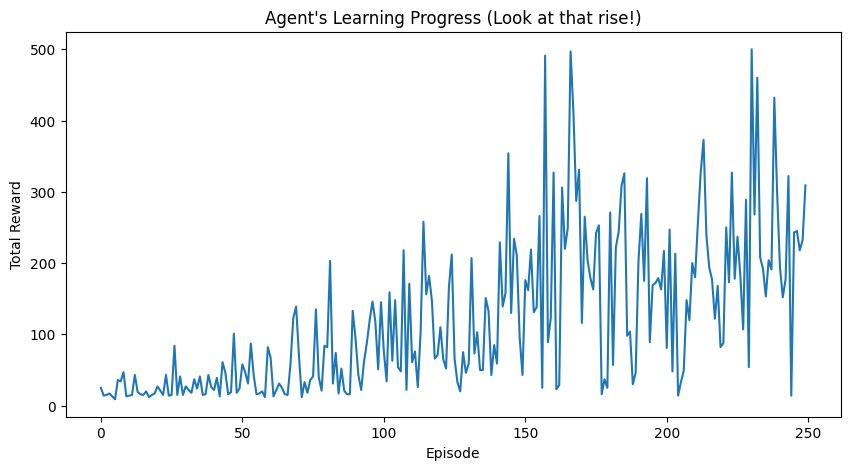

Recording showcase episode... (This might take a moment)


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Displaying video...


In [8]:
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import gymnasium as gym
import numpy as np
import base64
import os

# 3. Create the invisible screen to capture the video
print("Setting up virtual display...")
virtual_display = Display(visible=0, size=(400, 300))
virtual_display.start()

# 4. Plot the Learning Curve
if len(episode_rewards) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Agent's Learning Progress (Look at that rise!)")
    plt.show()

# 5. Record the Video
print("Recording showcase episode... (This might take a moment)")
env_to_render = gym.make("CartPole-v1", render_mode='rgb_array')
video_env = gym.wrappers.RecordVideo(env_to_render, './video', episode_trigger=lambda x: True)

# Play one perfect game for the camera
obs, info = video_env.reset()
done = False
while not done:
    # Use your trained 'model' from the previous step
    q_values = model(np.array([obs]), training=False)
    action = np.argmax(q_values[0])
    obs, reward, terminated, truncated, info = video_env.step(action)
    done = terminated or truncated

video_env.close()

# 6. Show the video
print("Displaying video...")
def show_video():
    mp4list = list(filter(lambda x: x.endswith('.mp4'), os.listdir('./video')))
    if len(mp4list) > 0:
        mp4 = mp4list[-1] # Pick the most recent video
        video_path = f'./video/{mp4}'
        video_file = open(video_path, "r+b").read()
        video_url = f"data:video/mp4;base64,{base64.b64encode(video_file).decode()}"
        return ipythondisplay.HTML(f"""<video width=400 controls autoplay loop><source src="{video_url}"></video>""")
    else:
        return "Could not find video"

show_video()